# **Figure ?.** Reynolds Stress
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created |  5/19/2022          |
| Updated |  7/22/2022          |

## Reynolds Stress
Ignoring the Maxwell (magnetic) stress tensor for purely hydrodynamic (unmagnetized) disks, the outward component of the angular momentum flux (turbulent transport) is the dominant $r\phi$ component (in cylindrical coordinates) of the Reynolds (velocity) stress tensor [(Baulbus & Hawley, 1998, Eq. 37)](https://doi.org/10.1103/RevModPhys.70.1)
\begin{equation}
    W_{r\phi} \equiv \langle u_ru_\phi\rangle_\rho,
    \tag{37*}
\end{equation}
where
\begin{equation}
    \langle u_ru_\phi\rangle_\rho = \frac{1}{2\pi\Sigma\Delta r}\int u_ru_\phi\,\mathrm{d}\phi\,\mathrm{d}r\,\mathrm{d}z,
    \tag{36*}
\end{equation}
and the surface density $\Sigma = \int_{-\infty}^\infty\rho_\mathrm{g}\,\mathrm{d}z$.
The *fluctuation velocity* $\mathbf{u}$ is the difference between the fluid velocity $\mathbf{v}$ and the azimuthal circular velocity $r\Omega$, where
\begin{equation}
    u_r = v_r,\quad u_\phi = v_\phi-r\Omega,\quad u_z = v_z.
    \tag{31}
\end{equation}

For our AB and BA simulations, the homogeneous fluid (gas) density is initially unity, i.e., $\rho_\mathrm{g}=1$.

However, the above definitions from [Baulbus & Hawley (1998)](https://doi.org/10.1103/RevModPhys.70.1) are not specific enough for our scenario during the saturated state which includes dust feedback to the gas and a radial pressure gradient.
Thus, we must calculate deviations from the [Nakagawa-Sekiya-Hayashi (1986)](https://ui.adsabs.harvard.edu/abs/1986Icar...67..375N/abstract) equlibrium state as follows:
\begin{align*}
    W_{r\phi} &\equiv \langle\rho_\mathrm{g}\delta u_r\delta u_\phi\rangle \\
    &= \langle\rho_\mathrm{g}(u_r - \overline{u_r})(u_\phi - \overline{u_\phi})\rangle \\
    &= \langle\rho_\mathrm{g} u_ru_\phi\rangle - \langle\rho_\mathrm{g} u_r\overline{u_\phi}\rangle - \langle\rho_\mathrm{g}\overline{u_r}u_\phi\rangle + \langle\overline{u_r}\rho_\mathrm{g}\overline{u_\phi}\rangle \\
    &= \langle\rho_\mathrm{g} u_ru_\phi\rangle - \overline{u_\phi}\langle\rho_\mathrm{g} u_r\rangle - \overline{u_r}\langle\rho_\mathrm{g} u_\phi\rangle + \overline{u_r}(\overline{u_\phi}),
\end{align*}
where, in the last term of the last line, we used the fact that $\langle\rho_\mathrm{g}\rangle = \overline{\rho_\mathrm{g}} = 1$, and where the $n$-th moment
\begin{equation}
    \langle g(x, y, z, t)^n \rangle \equiv \frac{1}{M_\mathrm{g}}\int\int\int g(x, y, z, t)^n\rho_\mathrm{g}(x, y, z, t) \mathrm{d}x\mathrm{d}y\mathrm{d}z
\end{equation}
is the volume average of a time-varying gas quantity $g$ over the computational domain, $M_\mathrm{g}$ is the total mass of the gas, $\rho_\mathrm{g}(x, y, z, t)$ is the local gas density at time $t$, and the discretised averages are
\begin{align*}
    \overline{u_{r,\phi}} &= \frac{\sum\rho_\mathrm{g} u_{r,\phi}}{\sum\rho_\mathrm{g}}, \\
    \overline{u_r}(\overline{u_\phi}) &= \frac{\sum\rho_\mathrm{g} u_r\left(\sum\rho_\mathrm{g} u_\phi\right)}{\left(\sum\rho_\mathrm{g}\right)^2}.
\end{align*}


### Athena++ `SI.hst` Outputs
- [Wiki](https://github.com/PrincetonUniversity/athena/wiki/Outputs#history-file): `1-mom`, etc. are global sums, i.e., total momenta in each direction.
  - `scr/outputs/history.cpp`, 141–150:
    ```cpp
    // Hydro conserved variables:
    Real& u_d  = phyd->u(IDN,k,j,i);
    Real& u_mx = phyd->u(IM1,k,j,i);
    Real& u_my = phyd->u(IM2,k,j,i);
    Real& u_mz = phyd->u(IM3,k,j,i);

    hst_data[0] += vol(i)*u_d;
    hst_data[1] += vol(i)*u_mx;
    hst_data[2] += vol(i)*u_my;
    hst_data[3] += vol(i)*u_mz;
    ```
  - $\overline{u_r} = $`1-mom`$/M_\mathrm{g}$
  - $\overline{u_\phi} = $`3-mom`$/M_\mathrm{g}$
  - $\overline{u_z} = $`2-mom`$/M_\mathrm{g}$
- Reuse the history file's existing `dux` and `duy` columns from the `Dux()` and `Duy()` problem generator (pgen) functions.
  - `src/pgen/streaming_instability.cpp`, lines 95-121:
    ```cpp
    //======================================================================================
    //! \fn Real Dux(MeshBlock *pmb, int iout)
    //  \brief Finds the first moment of the radial velocity deviation of the gas.
    //======================================================================================
    Real Dux(MeshBlock *pmb, int iout)
    {
        ...
              integral += rho(k,j,i) * (ux(k,j,i) - ux0) * pcoord->GetCellVolume(k,j,i);
        
        // Return the moment.
        return integral;
    }
    ```
  - $\langle \rho_\mathrm{g}u_r\rangle = $`dux`$/V_\mathrm{tot}$
  - [x] Check if `ux0` and `uy0` equal first line under `1-mom` and `3-mom`, respectively
    ``` cpp
    // Find the Nakagawa-Sekiya-Hayashi (1986) equilibrium solution.
    Real taus(omega * DustParticles::GetStoppingTime());
    Real v(duy0 / (std::pow(1.0 + epsilon, 2) + std::pow(taus, 2)));
    ux0 = 2.0 * epsilon * taus * v;
    uy0 = -((1.0 + epsilon) + std::pow(taus, 2)) * v;
    ```
- Add and enroll `DuxDuy()` to the pgen for a new `duxduy` history column.
  - `src/pgen/streaming_instability.cpp`, lines 211-242:  
    ```cpp
    //======================================================================================
    //! \fn Real DuxDuy(MeshBlock *pmb, int iout)
    //  \brief Finds the product of the first moments of the radial and azimuthal velocity
    //         deviations of the gas.
    //======================================================================================
    Real DuxDuy(MeshBlock *pmb, int iout)
    {
            ...
            Real dux(ux(k,j,i) - ux0);
            Real duy(uy(k,j,i) - uy0);
            integral += rho(k,j,i) * (dux * duy) * pcoord->GetCellVolume(k,j,i);
          }

    // Return the product of the moments.
    return integral;
    }
    ```
  - $\langle\rho_\mathrm{g} u_ru_\phi\rangle = $`duxduy`$/V_\mathrm{tot}$
- (Old)
    - [ ] Given $\rho_\mathrm{g}=1$, does $\Sigma=1$?
      

### Turbulent $\alpha$ Parameter
From [Baulbus & Hawley (1998)](https://doi.org/10.1103/RevModPhys.70.1), Eq. 48,
\begin{equation*}
    W_{r\phi} = \alpha c_\mathrm{s}^2
\end{equation*}
where $c_\mathrm{s}$ is the sound speed.

AB
	𝛼_𝑥𝑦 = aΠᵏ
		a = -3.0e-02 ± 2.8e-04
		k =  2.0e+00 ± 2.4e-03
	𝛼_𝑥𝑧 = aΠᵏ


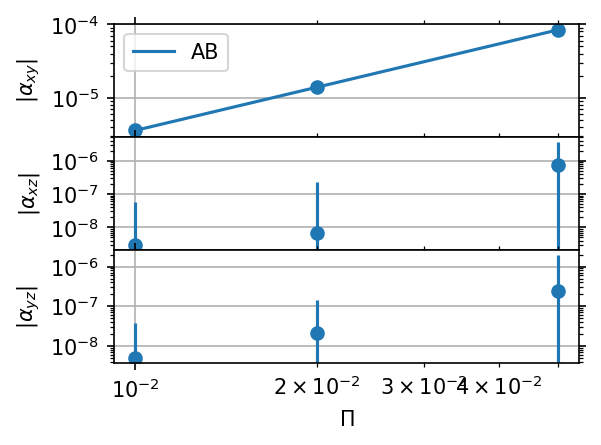

,Run,𝑊_𝑥𝑦 / 𝜌₀𝑐ₛ²,𝜎_𝑊_𝑥𝑦 / 𝜌₀𝑐ₛ²,𝑊_𝑥𝑧 / 𝜌₀𝑐ₛ²,𝜎_𝑊_𝑥𝑧 / 𝜌₀𝑐ₛ²,𝑊_𝑦𝑧 / 𝜌₀𝑐ₛ²,𝜎_𝑊_𝑦𝑧 / 𝜌₀𝑐ₛ²
0,AB/0.01,-1.4e-04,±6.4e-06,1.2e-07,±2.1e-06,-1.9e-07,±1.3e-06
1,AB/0.02,-5.5e-04,±6.5e-06,-2.6e-07,±9.0e-06,8.5e-07,±4.9e-06
2,AB/0.05,-3.3e-03,±1.0e-04,3.0e-05,±1.1e-04,-9.4e-06,±6.6e-05


In [6]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

fig, axs = plt.subplots(3, 1, sharex='col', figsize=(4, 3), dpi=150)
workdir = '../unstrat'
cases = [['AB', 2.0, 'tab:blue']]#, ['BA', 20.0, 'tab:orange']]
Pis = [0.01, 0.02, 0.05]#, 0.10]
res = '2048'
runs = []
Wxy_avg, Wxz_avg, Wyz_avg = [], [], []
Wxy_std, Wxz_std, Wyz_std = [], [], []
alpha_xy_avg, alpha_xz_avg, alpha_yz_avg = [[], []], [[], []], [[], []]
alpha_xy_std, alpha_xz_std, alpha_yz_std = [[], []], [[], []], [[], []]
func = lambda x, a, k : a*x**k # power-law model function

for i, case in enumerate(cases):
    for j, Pi in enumerate(Pis):
        runs.append(f'{case[0]}/{Pi:.2f}')
        path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
        athinput = athena_read.athinput(f'{path}/athinput.si')
        hst = athena_read.hst(f'{path}/output/SI.hst')
        c_s = athinput['hydro']['iso_sound_speed']
        dt = athinput['output3']['dt']
        Lx = athinput['mesh']['x1max'] - athinput['mesh']['x1min']
        Ly = athinput['mesh']['x2max'] - athinput['mesh']['x2min']
        Lz = athinput['mesh']['x3max'] - athinput['mesh']['x3min']
        Mg = V = Lx*Ly*Lz
        t_sat = case[1]
        if case == 'AB' and Pi == 0.01:
            t_sat = 4.0
        i_sat = int(t_sat/dt)

        # Collect average gas velocities and compute Reynolds stress and alpha
        ux_bar = hst['1-mom'][i_sat:]/Mg
        uy_bar = hst['3-mom'][i_sat:]/Mg
        duz = uz_bar = hst['2-mom'][i_sat:]/Mg
        dux = hst['dux'][i_sat:]/V
        duy = hst['duy'][i_sat:]/V
        duxduy = hst['duxduy'][i_sat:]/V
        duxduz = hst['duxduz'][i_sat:]/V
        duyduz = hst['duyduz'][i_sat:]/V
        Wxy = duxduy - uy_bar*dux - ux_bar*duy + ux_bar*uy_bar
        Wxz = duxduz - uz_bar*dux - ux_bar*duz + ux_bar*uz_bar
        Wyz = duyduz - uz_bar*duy - uy_bar*duz + uy_bar*uz_bar
        Wxy_avg.append(np.average(Wxy))
        Wxy_std.append(np.std(Wxy))
        Wxz_avg.append(np.average(Wxz))
        Wxz_std.append(np.std(Wxz))
        Wyz_avg.append(np.average(Wyz))
        Wyz_std.append(np.std(Wyz))
        alpha_xy_avg[i].append(np.average(Wxy)/c_s**2)
        alpha_xy_std[i].append(np.std(Wxy)/c_s**2)
        alpha_xz_avg[i].append(np.average(Wxz)/c_s**2)
        alpha_xz_std[i].append(np.std(Wxz)/c_s**2)
        alpha_yz_avg[i].append(np.average(Wyz)/c_s**2)
        alpha_yz_std[i].append(np.std(Wyz)/c_s**2)

    # Compute power-law best fit of alpha(Pi) and print parameters
    popt_xy, pcov_xy = curve_fit(func, Pis, alpha_xy_avg[i], sigma=alpha_xy_std[i])
    perr_xy = np.sqrt(np.diag(pcov_xy))
    # popt_xz, pcov_xz = curve_fit(func, Pis, alpha_xz_avg[i], sigma=alpha_xz_std[i])
    # perr_xz = np.sqrt(np.diag(pcov_xz))
    # popt_yz, pcov_yz = curve_fit(func, Pis, alpha_yz_avg[i], sigma=alpha_yz_std[i])
    # perr_yz = np.sqrt(np.diag(pcov_yz))
    print(f'{case[0]}')
    print('\t𝛼_𝑥𝑦 = aΠᵏ')
    print(f'\t\ta = {popt_xy[0]:8.1e} ± {perr_xy[0]:.1e}')
    print(f'\t\tk = {popt_xy[1]:8.1e} ± {perr_xy[1]:.1e}')
    print('\t𝛼_𝑥𝑧 = aΠᵏ')
    # print(f'\t\ta = {popt_xz[0]:8.1e} ± {perr_xz[0]:.1e}')
    # print(f'\t\tk = {popt_xz[1]:8.1e} ± {perr_xz[1]:.1e}')
    # print('\t𝛼_𝑦𝑧 = aΠᵏ')
    # print(f'\t\ta = {popt_yz[0]:8.1e} ± {perr_yz[0]:.1e}')
    # print(f'\t\tk = {popt_yz[1]:8.1e} ± {perr_yz[1]:.1e}')

    # Plot alpha values and best fits
    axs[0].errorbar(Pis, np.abs(alpha_xy_avg[i]), alpha_xy_std[i], fmt='o', color=case[2])
    axs[0].plot(Pis, np.abs(func(np.asarray(Pis), *popt_xy)), label=f'{case[0]}',
            color=case[2])
    axs[1].errorbar(Pis, np.abs(alpha_xz_avg[i]), alpha_xz_std[i], fmt='o', color=case[2])
    # axs[1].plot(Pis, np.abs(func(np.asarray(Pis), *popt_xz)), label=f'{case[0]}',
    #         color=case[2])
    axs[2].errorbar(Pis, np.abs(alpha_yz_avg[i]), alpha_yz_std[i], fmt='o', color=case[2])
    # axs[2].plot(Pis, np.abs(func(np.asarray(Pis), *popt_yz)), label=f'{case[0]}',
    #         color=case[2])

# Format subplots
axs[0].legend()
axs[0].set(ylabel=r'|$\alpha_{xy}$|')
axs[1].set(ylabel=r'|$\alpha_{xz}$|')
axs[2].set(ylabel=r'|$\alpha_{yz}$|', xlabel='$\Pi$')
fig.subplots_adjust(hspace=0)

for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(which='both', top=True, right=True)

plt.show()

df = pd.DataFrame({
    'Run'            : runs,
    '𝑊_𝑥𝑦 / 𝜌₀𝑐ₛ²'   : Wxy_avg,
    '𝜎_𝑊_𝑥𝑦 / 𝜌₀𝑐ₛ²' : Wxy_std,
    # '𝛼_𝑥𝑦 / 𝜌₀'      : np.asarray(alpha_xy_avg).flat,
    # '𝜎_𝛼_𝑥𝑦 / 𝜌₀'    : np.asarray(alpha_xy_std).flat,
    '𝑊_𝑥𝑧 / 𝜌₀𝑐ₛ²'   : Wxz_avg,
    '𝜎_𝑊_𝑥𝑧 / 𝜌₀𝑐ₛ²' : Wxz_std,
    # '𝛼_𝑥𝑧 / 𝜌₀'      : np.asarray(alpha_xz_avg).flat,
    # '𝜎_𝛼_𝑥𝑧 / 𝜌₀'    : np.asarray(alpha_xz_std).flat,
    '𝑊_𝑦𝑧 / 𝜌₀𝑐ₛ²'   : Wyz_avg,
    '𝜎_𝑊_𝑦𝑧 / 𝜌₀𝑐ₛ²' : Wyz_std,
    # '𝛼_𝑦𝑧 / 𝜌₀'      : np.asarray(alpha_yz_avg).flat,
    # '𝜎_𝛼_𝑦𝑧 / 𝜌₀'    : np.asarray(alpha_yz_std).flat,
    })
df.style.format({
    '𝑊_𝑥𝑦 / 𝜌₀𝑐ₛ²'   : '{:.1e}',
    '𝜎_𝑊_𝑥𝑦 / 𝜌₀𝑐ₛ²' : '±{:.1e}',
    # '𝛼_𝑥𝑦 / 𝜌₀'      : '{:.1e}',
    # '𝜎_𝛼_𝑥𝑦 / 𝜌₀'    : '±{:.1e}',
    '𝑊_𝑥𝑧 / 𝜌₀𝑐ₛ²'   : '{:.1e}',
    '𝜎_𝑊_𝑥𝑧 / 𝜌₀𝑐ₛ²' : '±{:.1e}',
    # '𝛼_𝑥𝑧 / 𝜌₀'      : '{:.1e}',
    # '𝜎_𝛼_𝑥𝑧 / 𝜌₀'    : '±{:.1e}',
    '𝑊_𝑦𝑧 / 𝜌₀𝑐ₛ²'   : '{:.1e}',
    '𝜎_𝑊_𝑦𝑧 / 𝜌₀𝑐ₛ²' : '±{:.1e}',
    # '𝛼_𝑦𝑧 / 𝜌₀'      : '{:.1e}',
    # '𝜎_𝛼_𝑦𝑧 / 𝜌₀'    : '±{:.1e}',
    })
